## DEMs coregistration demo
### !! The data for co-registration should be utm projected.
### Taking srtm and tandem dems as example.


In [1]:
import os
root_proj = '/Users/luo/OneDrive/GitHub/Glacier-in-RGI1305'
os.chdir(root_proj)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
from utils.raster_vec import vec2mask
import xdem
from matplotlib.colors import LinearSegmentedColormap

In [3]:
path_tandem = 'data/dem-data/tandem-x/TDM1_DEM__30_N36E078_V01_C/DEM/TDM1_DEM__30_N36E078_DEM.tif'   # slave dem
path_dem = 'data/aster-stereo/2009-36-78/dems_2009_mosaic_subs.tif'
path_water_jrc = 'data/water_jrc/water_jrc_36_78.tif'   # jrc water map for water mask
path_rgi = 'data/rgi60/rgi60_36_78.gpkg'                # rgi glacier data for glacier mask
path_dem_aligned = 'data/aster-stereo/2009-36-78/dems_mosaic_subs_coreg.tif'



### 1. Check dem images, and water/glacier mask images.

tandem: (3061, 3061) dem: (3061, 3061)
(1, 3061, 3061)


Text(0.5, 1.0, 'wat_gla_mask')

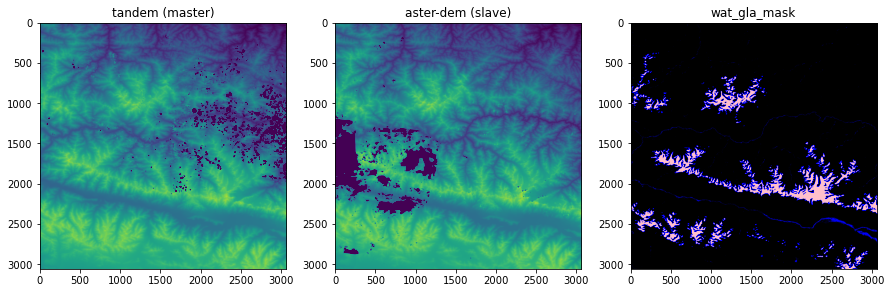

In [4]:
cmap = LinearSegmentedColormap.from_list('linear color', ["Black", 'Blue', 'Pink'])
_, dem_info = readTiff(path_dem)         # master dem
### --1. data reading
dem = xdem.DEM(path_dem)      # slave dem
tandem = xdem.DEM(path_tandem).reproject(dem)  # master dem 
dem = dem.reproject(tandem)   # ensure the geo-info are completely the same. some bug for the xdem
print('tandem:', tandem.shape, 'dem:', dem.shape)

### --2.water/glacier mask (water:1, glacier:2, other:0)
water_jrc = xdem.DEM(path_water_jrc).reproject(dem)
rgi60_mask = vec2mask(path_vec=path_rgi, path_raster=path_dem, path_save=None)
wat_gla_mask = water_jrc.data[0]+rgi60_mask*2
### --3. image visualize
print(tandem.data.shape)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(tandem.data[0], vmin=2000, vmax=7000); plt.title('tandem (master)')
plt.subplot(1,3,2); plt.imshow(dem.data[0], vmin=2000, vmax=7000); plt.title('aster-dem (slave)')
plt.subplot(1,3,3); plt.imshow(wat_gla_mask, vmin=0, vmax=2, cmap=cmap); plt.title('wat_gla_mask')
# plt.subplot(2,2,4); plt.imshow(rgi60_mask, vmin=0, vmax=1); plt.title('glacier_mask')


### **2. Co-registration to srtm-c dem by using open-source pybob code.**
##### (Reference: Nuth and Kääb (2011) (https://www.the-cryosphere.net/5/271/2011/tc-5-271-2011.html))


Text(0.5, 1.0, 'water and glacier mask image')

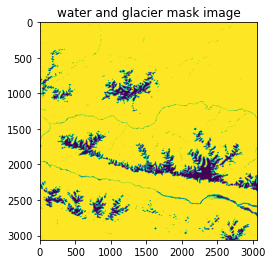

In [5]:
mask_img = np.ma.masked_equal(wat_gla_mask ,0).mask
plt.imshow(mask_img)
plt.title('water and glacier mask image')

In [6]:
nuth_kaab = xdem.coreg.NuthKaab(max_iterations=20, offset_threshold=0.005) # offset_threshold is the distance threshold
nuth_kaab.fit(reference_dem=tandem, dem_to_be_aligned= dem, inlier_mask=mask_img, verbose=True)
dem_aligned = nuth_kaab.apply(dem)


Running Nuth and Kääb (2011) coregistration
   Calculate slope and aspect
   Statistics on initial dh:
      Median = 18.19 - NMAD = 30.76
   Iteratively estimating horizontal shit:


   Progress:   0%|          | 0/20 [00:01<?, ?it/s]

      #1 - Offset in pixels : (-0.09, -0.11)


   Progress:   5%|▌         | 1/20 [00:02<00:47,  2.50s/it]

      Median = 18.39 - NMAD = 30.93  ==>  Gain = 0.55%


   Progress:   5%|▌         | 1/20 [00:04<00:47,  2.50s/it]

      #2 - Offset in pixels : (-0.03, -0.04)


   Progress:  10%|█         | 2/20 [00:04<00:43,  2.44s/it]

      Median = 18.40 - NMAD = 30.88  ==>  Gain = -0.18%


   Progress:  10%|█         | 2/20 [00:06<00:43,  2.44s/it]

      #3 - Offset in pixels : (-0.01, -0.01)


   Progress:  15%|█▌        | 3/20 [00:07<00:40,  2.39s/it]

      Median = 18.40 - NMAD = 30.87  ==>  Gain = -0.02%


   Progress:  15%|█▌        | 3/20 [00:08<00:40,  2.39s/it]

      #4 - Offset in pixels : (-0.01, -0.00)


   Progress:  20%|██        | 4/20 [00:09<00:37,  2.32s/it]

      Median = 18.40 - NMAD = 30.87  ==>  Gain = -0.01%


   Progress:  20%|██        | 4/20 [00:11<00:37,  2.32s/it]

      #5 - Offset in pixels : (-0.00, -0.00)


   Progress:  20%|██        | 4/20 [00:11<00:46,  2.90s/it]


      Median = 18.40 - NMAD = 30.86  ==>  Gain = -0.00%
   Last offset was below the residual offset threshold of 0.005 -> stopping

   Final offset in pixels (east, north) : (-0.145457, -0.174725)
   Statistics on coregistered dh:
      Median = 18.40 - NMAD = 30.86


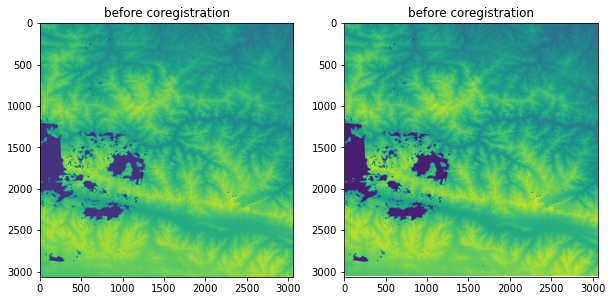

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(dem.data[0]); plt.title('before coregistration')
plt.subplot(1,2,2)
plt.imshow(dem_aligned.data[0]); plt.title('before coregistration')
writeTiff(dem_aligned.data[0], dem_info['geotrans'], dem_info['geosrs'], path_dem_aligned) 


### **3. Compare the dem difference before and after dems co-registration**

In [8]:

diff_before = tandem - dem      ## before coregistation
diff_after = tandem - dem_aligned      ## after coregistation
inliers_before = diff_before.data[0][mask_img].compressed()
med_before, nmad_before = np.nanmedian(inliers_before), xdem.spatialstats.nmad(inliers_before)
inliers_after = diff_after.data[0][mask_img].compressed()
med_after, nmad_after = np.nanmedian(inliers_after), xdem.spatialstats.nmad(inliers_after)
print(f"Error before: median diference = {med_before:.2f}; NMAD = {nmad_before:.2f} m")
print(f"Error after: median diference = {med_after:.2f}; NMAD = {nmad_after:.2f} m")


Error before: median diference = 18.19; NMAD = 30.76 m
Error after: median diference = -0.24; NMAD = 30.35 m


Text(0.5, 1.0, 'after co-registration')

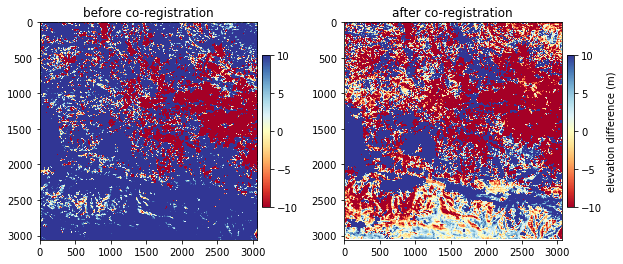

In [9]:
fig1 = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(diff_before.data[0], vmin=-10, vmax=10, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
plt.title('before co-registration')

plt.subplot(1,2,2)
plt.imshow(diff_after.data[0], vmin=-10, vmax=10, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
cb.set_label('elevation difference (m)')
plt.title('after co-registration')
